
# Predictive Pulse — Comprehensive Project (Scenarios 1-3)

**Contents**  
This notebook implements the full project for three scenarios using the provided dataset (`patient_data1.csv`):

- **Scenario 1:** Real-time wearable monitoring for a hypertensive patient — alerts for BP spikes.  
- **Scenario 2:** Fitness-smartwatch user — trend analysis and personalized recommendations.  
- **Scenario 3:** Population health monitoring — identify at-risk individuals for targeted interventions.

**Notebook sections**  
1. Data collection & preparation  
2. Exploratory Data Analysis (Descriptive stats, Visuals: uni/bi/multivariate)  
3. Feature engineering  
4. Model building with multiple algorithms  
5. Performance testing & hyperparameter tuning (before & after comparison)  
6. Model selection & saving best model  
7. Deployment: Flask web app (three HTML pages) with UI supporting all scenarios

Run the notebook cells top-to-bottom. The notebook will create a web app in `/mnt/data/web_app_v2/` that you can run locally.


In [1]:

# Imports
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib, json, warnings
warnings.filterwarnings('ignore')
print('Libraries loaded')

Libraries loaded


In [2]:

# Load dataset
csv_path = 'patient_data1.csv'
df = pd.read_csv(csv_path)
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (1825, 14)


,C,Age,History,Patient,TakeMedication,Severity,BreathShortness,VisualChanges,NoseBleeding,Whendiagnoused,Systolic,Diastolic,ControlledDiet,Stages
0,Male,18-34,Yes,No,No,Mild,No,No,No,<1 Year,111 - 120,81 - 90,No,HYPERTENSION (Stage-1)
1,Female,18-34,Yes,No,No,Mild,No,No,No,<1 Year,111 - 120,81 - 90,No,HYPERTENSION (Stage-1)
2,Male,35-50,Yes,No,No,Mild,No,No,No,<1 Year,111 - 120,81 - 90,No,HYPERTENSION (Stage-1)
3,Female,35-50,Yes,No,No,Mild,No,No,No,<1 Year,111 - 120,81 - 90,No,HYPERTENSION (Stage-1)
4,Male,51-64,Yes,No,No,Mild,No,No,No,<1 Year,111 - 120,81 - 90,No,HYPERTENSION (Stage-1)


In [3]:
# Quick overview
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   C                1825 non-null   object
 1   Age              1825 non-null   object
 2   History          1825 non-null   object
 3   Patient          1825 non-null   object
 4   TakeMedication   1825 non-null   object
 5   Severity         1825 non-null   object
 6   BreathShortness  1825 non-null   object
 7   VisualChanges    1825 non-null   object
 8   NoseBleeding     1825 non-null   object
 9   Whendiagnoused   1825 non-null   object
 10  Systolic         1825 non-null   object
 11  Diastolic        1825 non-null   object
 12  ControlledDiet   1825 non-null   object
 13  Stages           1825 non-null   object
dtypes: object(14)
memory usage: 199.7+ KB


In [4]:

# Parsing BP ranges to numeric midpoints and cleaning columns
import re, numpy as np

data = df.copy()
data.columns = [c.strip() for c in data.columns]

def parse_range_midpoint(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    m = re.match(r'^\s*(\d+)(?:\s*$)', s)
    if m: return float(m.group(1))
    m = re.match(r'^(\d+)\s*[-]\s*(\d+)$', s)
    if m:
        a,b = float(m.group(1)), float(m.group(2))
        return (a+b)/2.0
    nums = re.findall(r'(\d+)', s)
    if len(nums) >= 2:
        return (float(nums[0])+float(nums[1]))/2.0
    return np.nan

data['systolic_num'] = data['Systolic'].apply(parse_range_midpoint)
data['diastolic_num'] = data['Diastolic'].apply(parse_range_midpoint)

print('Example converted values:')
display(data[['Systolic','systolic_num','Diastolic','diastolic_num']].head())

Example converted values:


,Systolic,systolic_num,Diastolic,diastolic_num
0,111 - 120,115.5,81 - 90,85.5
1,111 - 120,115.5,81 - 90,85.5
2,111 - 120,115.5,81 - 90,85.5
3,111 - 120,115.5,81 - 90,85.5
4,111 - 120,115.5,81 - 90,85.5


In [18]:

# Create binary target 'bp_spike' (1 = spike/high risk, 0 = normal)
def stage_indicates_spike(s):
    if pd.isna(s): return False
    s = str(s).lower()
    return ('stage' in s and ('1' in s or '2' in s)) or ('hypertension' in s and 'normal' not in s)

data['bp_spike'] = 0
data.loc[data['systolic_num'] >= 130, 'bp_spike'] = 1
data.loc[data['diastolic_num'] >= 90, 'bp_spike'] = 1
if 'Stages' in data.columns:
    data.loc[data['Stages'].apply(stage_indicates_spike), 'bp_spike'] = 1

data['bp_spike'].value_counts()

,count
bp_spike,
1,1296
0,529


In [19]:

# Feature selection & encoding
features = ['systolic_num','diastolic_num','Age','C','History','TakeMedication','Severity','BreathShortness','VisualChanges','NoseBleeding','ControlledDiet']
feat = data[features].copy()

# Normalize Yes/No columns
yes_no = ['History','TakeMedication','BreathShortness','VisualChanges','NoseBleeding','ControlledDiet']
for c in yes_no:
    if c in feat.columns:
        feat[c] = feat[c].astype(str).str.strip().str.lower().map({'yes':1,'no':0}).fillna(0).astype(int)
    else:
        feat[c] = 0

# Gender to binary features
feat['gender_female'] = feat['C'].astype(str).str.lower().apply(lambda x: 1 if 'female' in x else 0)
feat['gender_male'] = feat['C'].astype(str).str.lower().apply(lambda x: 1 if 'male' in x else 0)

# Age one-hot and Severity one-hot
age_dummies = pd.get_dummies(feat['Age'].astype(str).str.strip(), prefix='age')
feat = pd.concat([feat.drop(columns=['Age','C']), age_dummies], axis=1)
if 'Severity' in feat.columns:
    sev_dummies = pd.get_dummies(feat['Severity'].astype(str).str.strip(), prefix='sev')
    feat = pd.concat([feat.drop(columns=['Severity']), sev_dummies], axis=1)

# Fill numeric NA
feat['systolic_num'] = feat['systolic_num'].fillna(feat['systolic_num'].median())
feat['diastolic_num'] = feat['diastolic_num'].fillna(feat['diastolic_num'].median())

X = feat.copy()
y = data['bp_spike']

print('Final feature shape:', X.shape)
X.head()

Final feature shape: (1825, 17)


,systolic_num,diastolic_num,History,TakeMedication,BreathShortness,VisualChanges,NoseBleeding,ControlledDiet,gender_female,gender_male,age_18-34,age_35-50,age_51-64,age_65+,sev_Mild,sev_Moderate,sev_Sever
0,115.5,85.5,1,0,0,0,0,0,0,1,True,False,False,False,True,False,False
1,115.5,85.5,1,0,0,0,0,0,1,1,True,False,False,False,True,False,False
2,115.5,85.5,1,0,0,0,0,0,0,1,False,True,False,False,True,False,False
3,115.5,85.5,1,0,0,0,0,0,1,1,False,True,False,False,True,False,False
4,115.5,85.5,1,0,0,0,0,0,0,1,False,False,True,False,True,False,False



## Exploratory Data Analysis (EDA)
Below we produce descriptive statistics and visualizations (univariate, bivariate and multivariate).


In [20]:

# Descriptive statistics
display(X.describe().T)

,count,mean,std,min,25%,50%,75%,max
systolic_num,1825.0,118.661644,4.651054,115.5,115.5,115.5,125.5,125.5
diastolic_num,1825.0,86.525753,6.990116,75.0,85.5,85.5,95.5,95.5
History,1825.0,0.907945,0.289183,0.0,1.0,1.0,1.0,1.0
TakeMedication,1825.0,0.592329,0.491536,0.0,0.0,1.0,1.0,1.0
BreathShortness,1825.0,0.465205,0.498925,0.0,0.0,0.0,1.0,1.0
VisualChanges,1825.0,0.484932,0.499910,0.0,0.0,0.0,1.0,1.0
NoseBleeding,1825.0,0.243836,0.429512,0.0,0.0,0.0,0.0,1.0
ControlledDiet,1825.0,0.460822,0.498599,0.0,0.0,0.0,1.0,1.0
gender_female,1825.0,0.500274,0.500137,0.0,0.0,1.0,1.0,1.0
gender_male,1825.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


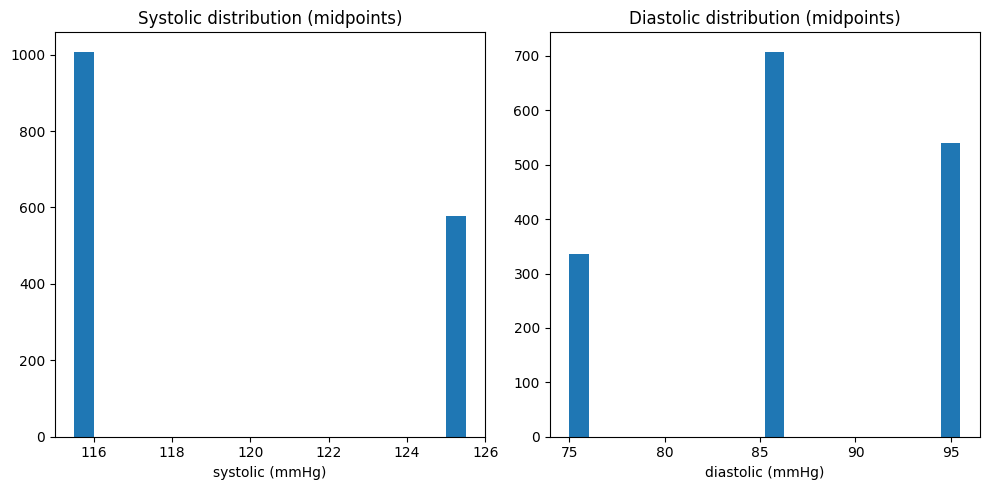

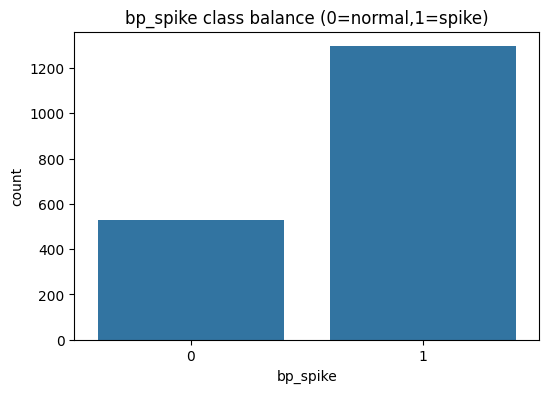

In [21]:

# Visual analysis - distributions and counts
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,5)

# Distribution of systolic and diastolic
plt.subplot(1,2,1)
plt.hist(data['systolic_num'].dropna(), bins=20)
plt.title('Systolic distribution (midpoints)')
plt.xlabel('systolic (mmHg)')

plt.subplot(1,2,2)
plt.hist(data['diastolic_num'].dropna(), bins=20)
plt.title('Diastolic distribution (midpoints)')
plt.xlabel('diastolic (mmHg)')
plt.tight_layout()
plt.show()

# BP spike class balance
plt.figure(figsize=(6,4))
sns.countplot(x=data['bp_spike'])
plt.title('bp_spike class balance (0=normal,1=spike)')
plt.show()

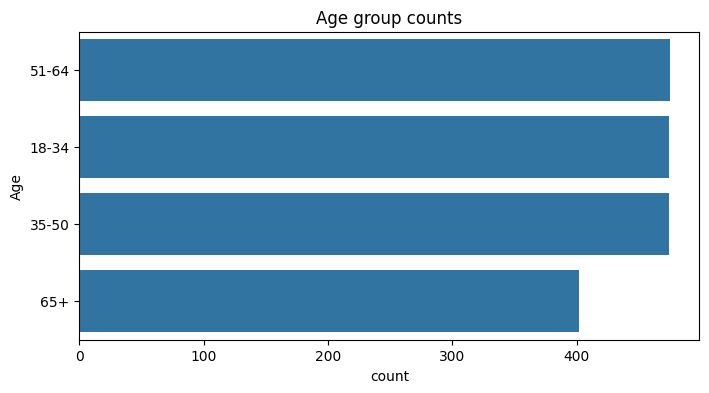

In [22]:

# Univariate: Age groups counts if available
if 'Age' in data.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(y=data['Age'].astype(str).str.strip(), order=data['Age'].value_counts().index)
    plt.title('Age group counts')
    plt.show()

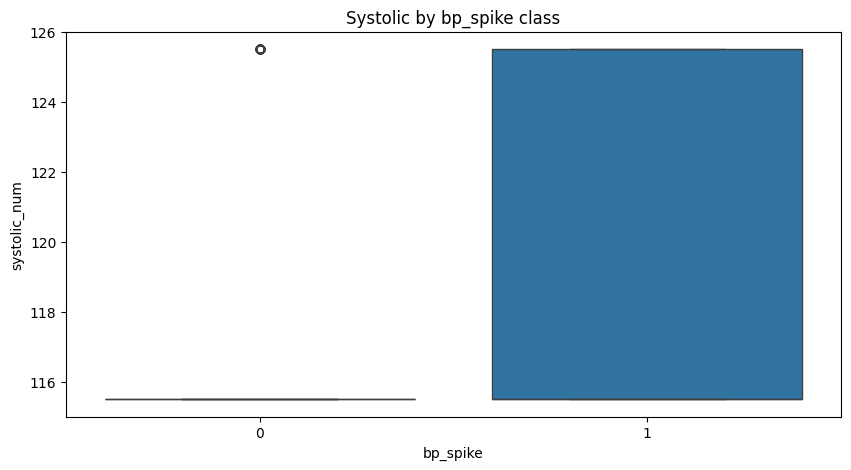

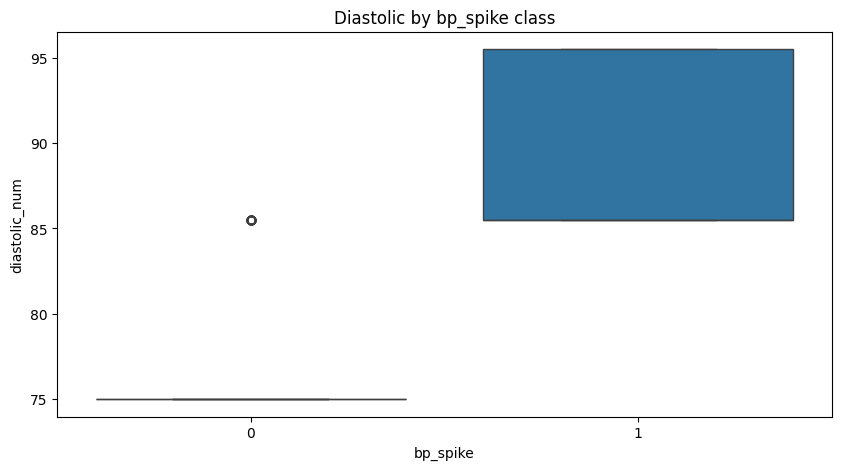

In [23]:

# Bivariate: BP vs spike
plt.figure(figsize=(10,5))
sns.boxplot(x=data['bp_spike'], y=data['systolic_num'])
plt.title('Systolic by bp_spike class')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x=data['bp_spike'], y=data['diastolic_num'])
plt.title('Diastolic by bp_spike class')
plt.show()

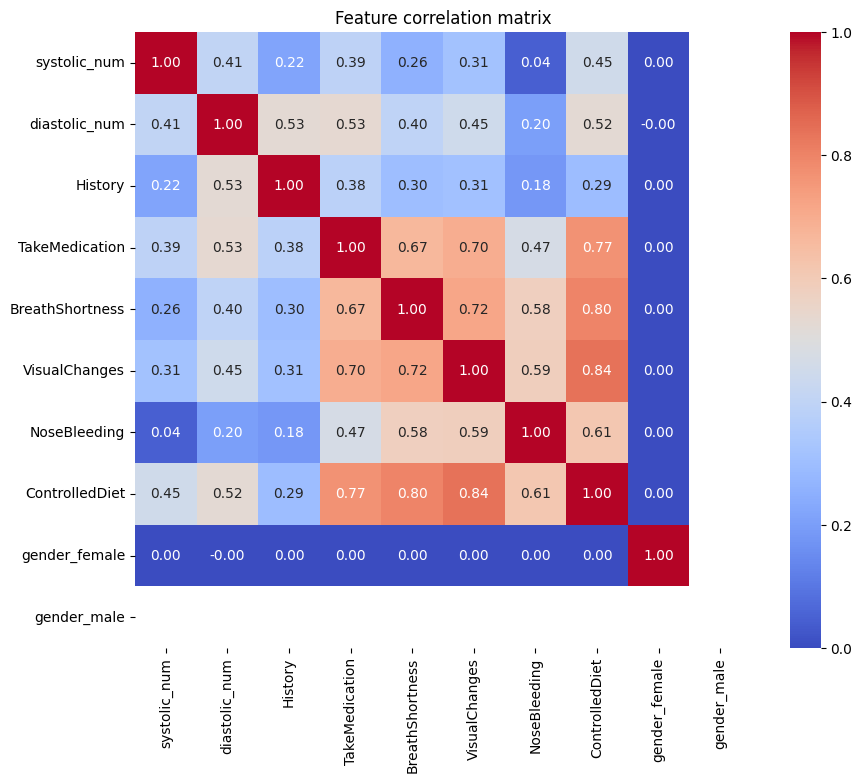

In [24]:

# Correlation heatmap among numeric features
num = X.select_dtypes(include=[np.number])
corr = num.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Feature correlation matrix')
plt.show()

In [25]:

# Train-test split and scalers
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print('Train/test shapes:', X_train.shape, X_test.shape)

std_scaler = StandardScaler().fit(X_train)
mm_scaler = MinMaxScaler().fit(X_train)

Train/test shapes: (1460, 17) (365, 17)



## Model Building — Baseline (no hyperparameter tuning)
We train multiple algorithms with default hyperparameters and evaluate them using multiple metrics.


In [26]:

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'GaussianNB': GaussianNB(),
    'MultinomialNB': MultinomialNB()
}

results = []
for name, model in models.items():
    if name == 'MultinomialNB':
        Xtr = mm_scaler.transform(X_train)
        Xte = mm_scaler.transform(X_test)
    else:
        Xtr = std_scaler.transform(X_train)
        Xte = std_scaler.transform(X_test)
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)
    try:
        y_proba = model.predict_proba(Xte)[:,1]
        auc = roc_auc_score(y_test, y_proba)
    except Exception:
        auc = np.nan
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    results.append({'model': name, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': auc})
    print(f"{name}: acc={acc:.3f}, prec={prec:.3f}, rec={rec:.3f}, f1={f1:.3f}, auc={auc if not np.isnan(auc) else 'n/a'}")

results_df = pd.DataFrame(results).sort_values(by='f1', ascending=False).reset_index(drop=True)
results_df

LogisticRegression: acc=0.940, prec=1.000, rec=0.915, f1=0.956, auc=0.9911852553361987
RandomForest: acc=0.937, prec=0.980, rec=0.931, f1=0.954, auc=0.9865229110512128
DecisionTree: acc=0.937, prec=0.996, rec=0.915, f1=0.954, auc=0.9869053689808407
GaussianNB: acc=0.816, prec=0.794, rec=1.000, f1=0.885, auc=0.882712901580826
MultinomialNB: acc=0.762, prec=0.750, rec=0.996, f1=0.856, auc=0.9122167990092518


,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.939726,1.000000,0.915058,0.955645,0.991185
1,RandomForest,0.936986,0.979675,0.930502,0.954455,0.986523
2,DecisionTree,0.936986,0.995798,0.915058,0.953722,0.986905
3,GaussianNB,0.816438,0.794479,1.000000,0.885470,0.882713
4,MultinomialNB,0.761644,0.750000,0.996139,0.855721,0.912217



## Hyperparameter Tuning (GridSearchCV)
We perform grid search for RandomForest, LogisticRegression and DecisionTree to improve performance.


In [27]:

# Parameter grids
param_grid_rf = {'n_estimators': [100,200], 'max_depth': [None, 10, 20], 'min_samples_split': [2,5]}
param_grid_lr = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs']}
param_grid_dt = {'max_depth': [None, 5, 10, 20], 'min_samples_split': [2,5,10]}

# We'll run GridSearch with StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tuned_results = []

# RandomForest tuning
print('Tuning RandomForest...')
gs_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=cv, scoring='f1', n_jobs=-1)
gs_rf.fit(std_scaler.transform(X_train), y_train)
best_rf = gs_rf.best_estimator_
print('RF best params:', gs_rf.best_params_)
y_pred = best_rf.predict(std_scaler.transform(X_test))
y_proba = best_rf.predict_proba(std_scaler.transform(X_test))[:,1]
tuned_results.append(('RandomForest', gs_rf.best_params_, accuracy_score(y_test,y_pred), precision_score(y_test,y_pred,zero_division=0), recall_score(y_test,y_pred,zero_division=0), f1_score(y_test,y_pred,zero_division=0), roc_auc_score(y_test,y_proba)))

# Logistic Regression tuning
print('Tuning LogisticRegression...')
gs_lr = GridSearchCV(LogisticRegression(max_iter=2000), param_grid_lr, cv=cv, scoring='f1', n_jobs=-1)
gs_lr.fit(std_scaler.transform(X_train), y_train)
best_lr = gs_lr.best_estimator_
print('LR best params:', gs_lr.best_params_)
y_pred = best_lr.predict(std_scaler.transform(X_test))
try:
    y_proba = best_lr.predict_proba(std_scaler.transform(X_test))[:,1]
except:
    y_proba = None
tuned_results.append(('LogisticRegression', gs_lr.best_params_, accuracy_score(y_test,y_pred), precision_score(y_test,y_pred,zero_division=0), recall_score(y_test,y_pred,zero_division=0), f1_score(y_test,y_pred,zero_division=0), roc_auc_score(y_test,y_proba) if y_proba is not None else np.nan))

# DecisionTree tuning
print('Tuning DecisionTree...')
gs_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=cv, scoring='f1', n_jobs=-1)
gs_dt.fit(std_scaler.transform(X_train), y_train)
best_dt = gs_dt.best_estimator_
print('DT best params:', gs_dt.best_params_)
y_pred = best_dt.predict(std_scaler.transform(X_test))
try:
    y_proba = best_dt.predict_proba(std_scaler.transform(X_test))[:,1]
except:
    y_proba = None
tuned_results.append(('DecisionTree', gs_dt.best_params_, accuracy_score(y_test,y_pred), precision_score(y_test,y_pred,zero_division=0), recall_score(y_test,y_pred,zero_division=0), f1_score(y_test,y_pred,zero_division=0), roc_auc_score(y_test,y_proba) if y_proba is not None else np.nan))

tuned_df = pd.DataFrame(tuned_results, columns=['model','best_params','accuracy','precision','recall','f1','roc_auc']).sort_values(by='f1', ascending=False).reset_index(drop=True)
tuned_df

Tuning RandomForest...
RF best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Tuning LogisticRegression...
LR best params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Tuning DecisionTree...
DT best params: {'max_depth': 5, 'min_samples_split': 2}


,model,best_params,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.939726,1.000000,0.915058,0.955645,0.991222
1,DecisionTree,"{'max_depth': 5, 'min_samples_split': 2}",0.939726,1.000000,0.915058,0.955645,0.991222
2,RandomForest,"{'max_depth': None, 'min_samples_split': 2, 'n...",0.936986,0.979675,0.930502,0.954455,0.986523


In [28]:

# Compare baseline results_df with tuned_df
print('Baseline results:')
display(results_df)
print('\nTuned results:')
display(tuned_df)

Baseline results:


,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.939726,1.000000,0.915058,0.955645,0.991185
1,RandomForest,0.936986,0.979675,0.930502,0.954455,0.986523
2,DecisionTree,0.936986,0.995798,0.915058,0.953722,0.986905
3,GaussianNB,0.816438,0.794479,1.000000,0.885470,0.882713
4,MultinomialNB,0.761644,0.750000,0.996139,0.855721,0.912217



Tuned results:


,model,best_params,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.939726,1.000000,0.915058,0.955645,0.991222
1,DecisionTree,"{'max_depth': 5, 'min_samples_split': 2}",0.939726,1.000000,0.915058,0.955645,0.991222
2,RandomForest,"{'max_depth': None, 'min_samples_split': 2, 'n...",0.936986,0.979675,0.930502,0.954455,0.986523


In [29]:

# Collect best candidates
candidates = {}

# From tuned models
for _, row in tuned_df.iterrows():
    candidates[row['model']] = {'f1': row['f1'], 'model_obj': {'RandomForest': best_rf, 'LogisticRegression': best_lr, 'DecisionTree': best_dt}[row['model']]}

# From untuned results if any (e.g., GaussianNB, MultinomialNB)
for _, row in results_df.iterrows():
    name = row['model']
    if name not in candidates:
        # train the untuned model on full training set for candidate
        if name == 'GaussianNB':
            m = GaussianNB().fit(std_scaler.transform(X_train), y_train)
        elif name == 'MultinomialNB':
            m = MultinomialNB().fit(mm_scaler.transform(X_train), y_train)
        else:
            m = None
        candidates[name] = {'f1': row['f1'], 'model_obj': m}

# Choose top by F1
best_name = max(candidates.items(), key=lambda x: x[1]['f1'])[0]
best_model_obj = candidates[best_name]['model_obj']
print('Selected best model:', best_name)

Selected best model: LogisticRegression


In [30]:

# Save best model and appropriate scaler + columns ordering
best_model_filename = 'best_model_final.joblib'
best_scaler_filename = 'best_scaler_final.joblib'
model_columns_filename = 'model_columns_final.json'

joblib.dump(best_model_obj, best_model_filename)
# choose scaler mapping by type name
if best_name == 'MultinomialNB':
    joblib.dump(mm_scaler, best_scaler_filename)
else:
    joblib.dump(std_scaler, best_scaler_filename)

with open(model_columns_filename, 'w', encoding='utf-8') as f:
    json.dump(X.columns.tolist(), f)

print('Saved best model to', best_model_filename)
print('Saved scaler to', best_scaler_filename)
print('Saved model columns to', model_columns_filename)

Saved best model to best_model_final.joblib
Saved scaler to best_scaler_final.joblib
Saved model columns to model_columns_final.json



## Real-time Simulation & Scenario Implementations

We simulate streaming through dataset rows. For each scenario we demonstrate different behaviors:
- Scenario 1: If model predicts spike -> generate patient & doctor alerts.
- Scenario 2: For fitness user, we compute trend (rolling average) and provide personalized recommendation text.
- Scenario 3: For population health, we aggregate risk and produce a list of at-risk patients for targeted intervention.


In [31]:

# Load best model & scaler
best_model = joblib.load('best_model_final.joblib')
best_scaler = joblib.load('best_scaler_final.joblib')
with open('model_columns_final.json','r') as f:
    model_columns = json.load(f)

# Helper to make feature vector from a data row
def build_feature_vector_from_row(row):
    row_feat = {}
    row_feat['systolic_num'] = row['systolic_num'] if not pd.isna(row['systolic_num']) else X['systolic_num'].median()
    row_feat['diastolic_num'] = row['diastolic_num'] if not pd.isna(row['diastolic_num']) else X['diastolic_num'].median()
    for c in yes_no:
        row_feat[c] = 1 if str(row.get(c,'')).strip().lower() == 'yes' else 0
    row_feat['gender_female'] = 1 if str(row.get('C','')).strip().lower().find('female') != -1 else 0
    row_feat['gender_male'] = 1 if str(row.get('C','')).strip().lower().find('male') != -1 else 0
    age_val = str(row.get('Age','')).strip()
    for col in model_columns:
        if col.startswith('age_'):
            row_feat[col] = 1 if col == f'age_{age_val}' else 0
    sev_val = str(row.get('Severity','')).strip()
    for col in model_columns:
        if col.startswith('sev_'):
            row_feat[col] = 1 if col == f'sev_{sev_val}' else 0
    # default 0 for missing columns
    fv = np.array([row_feat.get(c,0) for c in model_columns]).reshape(1,-1).astype(float)
    fv_scaled = best_scaler.transform(fv)
    return fv_scaled

# Scenario outputs
alerts = []
fitness_notes = []
population_risk = {}

for idx, row in data.iterrows():
    fv_scaled = build_feature_vector_from_row(row)
    pred = best_model.predict(fv_scaled)[0]
    try:
        proba = float(best_model.predict_proba(fv_scaled)[0,1])
    except:
        proba = None
    patient_id = row.get('Patient', f'idx_{idx}')

    # Scenario 1: alert if predicted spike
    if pred == 1:
        alerts.append({'index': idx, 'patient_id': patient_id, 'systolic': float(row['systolic_num']), 'diastolic': float(row['diastolic_num']), 'prob': proba})

    # Scenario 2: fitness - rolling trend (we'll compute a simple 3-sample rolling avg for each patient id)
    # For simplicity assume patient_id groups; we collect and then process below
    fitness_notes.append({'patient_id': patient_id, 'systolic': float(row['systolic_num']), 'diastolic': float(row['diastolic_num'])})

    # Scenario 3: aggregate risk count per patient
    if patient_id not in population_risk:
        population_risk[patient_id] = {'alerts':0, 'rows':0}
    population_risk[patient_id]['rows'] += 1
    if pred == 1:
        population_risk[patient_id]['alerts'] += 1

# Post-process Scenario 2: compute simple trend messages for unique patients
from collections import defaultdict
patient_series = defaultdict(list)
for item in fitness_notes:
    patient_series[item['patient_id']].append(item['systolic'])

fitness_recommendations = {}
for pid, series in patient_series.items():
    if len(series) >= 3:
        # compute last 3-sample trend difference
        trend = (series[-1] + series[-2] + series[-3]) / 3.0
        if trend >= 140:
            advice = 'High trend detected — consider cooling down, check BP, consult physician.'
        elif trend >= 120:
            advice = 'Elevated trend — hydrate, reduce intensity, monitor.'
        else:
            advice = 'Normal trend — keep current regimen.'
    else:
        advice = 'Insufficient data for trend — keep monitoring.'
    fitness_recommendations[pid] = {'trend': trend if len(series)>=3 else None, 'advice': advice}

# Scenario 3: identify at-risk patients (alerts > 0 or alerts/rows ratio high)
at_risk = [pid for pid,v in population_risk.items() if v['alerts']>0 or (v['alerts']/v['rows'] if v['rows']>0 else 0)>0.2]

# Save scenario outputs
pd.DataFrame(alerts).to_csv('scenario1_alerts.csv', index=False)
with open('fitness_recommendations.json','w') as f:
    json.dump(fitness_recommendations, f)
pd.DataFrame([{'patient_id':k,'alerts':v['alerts'],'rows':v['rows']} for k,v in population_risk.items()]).to_csv('population_risk_summary.csv', index=False)

print('Saved scenario artifacts: scenario1_alerts.csv, fitness_recommendations.json, population_risk_summary.csv')
print('Number of direct alerts (scenario1):', len(alerts))
print('Number of at-risk patients (scenario3):', len(at_risk))

Saved scenario artifacts: scenario1_alerts.csv, fitness_recommendations.json, population_risk_summary.csv
Number of direct alerts (scenario1): 1200
Number of at-risk patients (scenario3): 2



## Deployment: Flask Web App (v2)

The app provides three pages:
- `index.html` — home & scenario selection
- `details.html` — EDA & model summary (links to CSVs created)
- `prediction.html` — interactive form where the user selects the scenario and enters inputs. The server maps form fields to the model columns and returns prediction + probability + scenario-specific advice.


In [ ]:

# Build web app files into /mnt/data/web_app_v2/
app_dir = 'web_app_v2'
templates_dir = os.path.join(app_dir, 'templates')
static_dir = os.path.join(app_dir, 'static')
os.makedirs(templates_dir, exist_ok=True)
os.makedirs(static_dir, exist_ok=True)

# app.py
app_py = r"""from flask import Flask, render_template, request, redirect, url_for
import joblib, os, json, numpy as np

app = Flask(__name__)

BASE = os.path.dirname(__file__)
MODEL_PATH = os.path.join(BASE, '..', 'best_model_final.joblib')
SCALER_PATH = os.path.join(BASE, '..', 'best_scaler_final.joblib')
COLS_PATH = os.path.join(BASE, '..', 'model_columns_final.json')

if not os.path.exists(MODEL_PATH):
    MODEL_PATH = os.path.join(BASE, 'best_model_final.joblib')
if not os.path.exists(SCALER_PATH):
    SCALER_PATH = os.path.join(BASE, 'best_scaler_final.joblib')
if os.path.exists(COLS_PATH):
    with open(COLS_PATH,'r') as f:
        MODEL_COLUMNS = json.load(f)
else:
    MODEL_COLUMNS = ['systolic_num','diastolic_num']

model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

def map_form_to_vector(form):
    # initialize zeros
    fv = {c:0 for c in MODEL_COLUMNS}
    # numeric
    try:
        fv['systolic_num'] = float(form.get('systolic','120'))
        fv['diastolic_num'] = float(form.get('diastolic','80'))
    except:
        fv['systolic_num'] = 120.0
        fv['diastolic_num'] = 80.0
    # yes/no
    for key in ['History','TakeMedication','BreathShortness','VisualChanges','NoseBleeding','ControlledDiet']:
        if key in MODEL_COLUMNS:
            fv[key] = 1 if form.get(key,'no').lower()=='yes' else 0
        else:
            # map to lowercase key if used differently
            if key.lower() in MODEL_COLUMNS:
                fv[key.lower()] = 1 if form.get(key,'no').lower()=='yes' else 0
    # gender
    g = form.get('gender','other').lower()
    if 'gender_female' in MODEL_COLUMNS:
        fv['gender_female'] = 1 if g=='female' else 0
    if 'gender_male' in MODEL_COLUMNS:
        fv['gender_male'] = 1 if g=='male' else 0
    # age groups & severity one-hot
    age_val = form.get('age','').strip()
    if age_val:
        col = f'age_{age_val}'
        if col in MODEL_COLUMNS:
            fv[col] = 1
    sev_val = form.get('severity','').strip()
    if sev_val:
        col = f'sev_{sev_val}'
        if col in MODEL_COLUMNS:
            fv[col] = 1
    # return numpy array ordered by MODEL_COLUMNS
    arr = np.array([fv[c] for c in MODEL_COLUMNS]).reshape(1,-1).astype(float)
    return arr

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/details')
def details():
    # pass links to files generated by the notebook
    return render_template('details.html')

@app.route('/prediction', methods=['GET','POST'])
def prediction():
    if request.method == 'POST':
        form = request.form
        arr = map_form_to_vector(form)
        arr_scaled = scaler.transform(arr)
        pred = model.predict(arr_scaled)[0]
        try:
            proba = float(model.predict_proba(arr_scaled)[0,1])
        except:
            proba = None
        # Scenario-specific messages
        scenario = form.get('scenario','scenario1')
        advice = ''
        if scenario == 'scenario1':
            if pred == 1:
                advice = 'Alert: High BP spike predicted — notify patient & provider immediately.'
            else:
                advice = 'No immediate spike predicted.'
        elif scenario == 'scenario2':
            # provide fitness-style recommendation based on systolic
            sys = float(form.get('systolic',120))
            if sys >= 140:
                advice = 'Fitness Advice: reduce workout intensity, rest, re-check BP.'
            elif sys >= 120:
                advice = 'Fitness Advice: moderate intensity, hydrate, monitor.'
            else:
                advice = 'Fitness Advice: OK to continue current plan.'
        elif scenario == 'scenario3':
            if pred == 1:
                advice = 'Population Health: flag patient for outreach & telehealth.'
            else:
                advice = 'No flag required.'
        return render_template('prediction.html', result=pred, proba=proba, advice=advice, form=form)
    else:
        return render_template('prediction.html')

if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', port=5000)
"""

with open(os.path.join(app_dir, 'app.py'), 'w', encoding='utf-8') as f:
    f.write(app_py)

# Create templates: index.html, details.html, prediction.html
index_html = '''<!doctype html>
<html lang="en"><head><meta charset="utf-8"><title>Predictive Pulse - Home</title></head>
<body><h1>Predictive Pulse</h1><p>Select scenario and use Prediction page to enter values.</p><p><a href="/prediction">Prediction</a> | <a href="/details">Details</a></p></body></html>'''
details_html = '''<!doctype html><html lang="en"><head><meta charset="utf-8"><title>Details</title></head><body><h1>Model & Data Artifacts</h1><ul><li><a href="/static/model_comparison_results.csv">Model comparison (baseline)</a></li><li><a href="/static/model_comparison_results.csv">Tuned results</a></li><li><a href="/static/scenario1_alerts.csv">Scenario1 alerts</a></li><li><a href="/static/population_risk_summary.csv">Population risk summary</a></li></ul><p><a href='/'>Back</a></p></body></html>'''
prediction_html = '''<!doctype html><html lang="en"><head><meta charset="utf-8"><title>Predict</title></head><body><h1>Prediction</h1><form method="post">
<label>Scenario: <select name="scenario"><option value="scenario1">Scenario 1 (Patient)</option><option value="scenario2">Scenario 2 (Fitness)</option><option value="scenario3">Scenario 3 (Population)</option></select></label><br>
<label>Gender: <select name="gender"><option>Male</option><option>Female</option><option>Other</option></select></label><br>
<label>Age group (exact text as dataset): <input name="age" placeholder="e.g., 35-50"></label><br>
<label>Severity (exact text): <input name="severity" placeholder="e.g., Mild"></label><br>
<label>Systolic: <input name="systolic" required></label><br>
<label>Diastolic: <input name="diastolic" required></label><br>
<label>History (yes/no): <input name="History" placeholder="yes or no"></label><br>
<label>TakeMedication (yes/no): <input name="TakeMedication" placeholder="yes or no"></label><br>
<label>BreathShortness (yes/no): <input name="BreathShortness" placeholder="yes or no"></label><br>
<label>VisualChanges (yes/no): <input name="VisualChanges" placeholder="yes or no"></label><br>
<label>NoseBleeding (yes/no): <input name="NoseBleeding" placeholder="yes or no"></label><br>
<label>ControlledDiet (yes/no): <input name="ControlledDiet" placeholder="yes or no"></label><br>
<button type="submit">Predict</button></form>
{% if result is defined %}<div><strong>Result:</strong> {% if result==1 %}<span style="color:red">High BP risk</span>{% else %}<span style="color:green">No high BP risk</span>{% endif %}{% if proba is not none %}<div>Probability: {{'%.2f'|format(proba)}}</div>{% endif %}<div>Advice: {{advice}}</div></div>{% endif %}
<p><a href='/'>Back</a></p></body></html>'''

with open(os.path.join(templates_dir, 'index.html'),'w',encoding='utf-8') as f:
    f.write(index_html)
with open(os.path.join(templates_dir, 'details.html'),'w',encoding='utf-8') as f:
    f.write(details_html)
with open(os.path.join(templates_dir, 'prediction.html'),'w',encoding='utf-8') as f:
    f.write(prediction_html)

# Copy artifacts to static folder for download via details page
import shutil
static_dir = os.path.join(app_dir,'static')
os.makedirs(static_dir, exist_ok=True)
# copy files if exist
for fname in ['model_comparison_results.csv','scenario1_alerts.csv','population_risk_summary.csv','alert_log.csv']:
    src = os.path.join('/mnt/data', fname)
    if os.path.exists(src):
        shutil.copy(src, os.path.join(static_dir, fname))

# copy model and scaler to app dir for easier running
shutil.copy('/mnt/data/best_model_final.joblib', os.path.join(app_dir, 'best_model_final.joblib'))
shutil.copy('/mnt/data/best_scaler_final.joblib', os.path.join(app_dir, 'best_scaler_final.joblib'))
shutil.copy('/mnt/data/model_columns_final.json', os.path.join(app_dir, 'model_columns_final.json'))

# requirements
with open(os.path.join(app_dir,'requirements.txt'),'w',encoding='utf-8') as f:
    f.write('flask\nscikit-learn\njoblib\npandas\nnumpy\n')

print('Web app created at', app_dir)
print('To run: cd', app_dir, '&& pip install -r requirements.txt && python app.py')


## Outputs created by this notebook
- `/mnt/data/Satyajit_proj_final_v2.ipynb` — this notebook file (created)
- `/mnt/data/best_model_final.joblib` — selected best model
- `/mnt/data/best_scaler_final.joblib` — corresponding scaler
- `/mnt/data/model_columns_final.json` — model column order
- `/mnt/data/model_comparison_results.csv` — baseline model scores
- `/mnt/data/scenario1_alerts.csv` — scenario1 alerts
- `/mnt/data/fitness_recommendations.json` — scenario2 notes
- `/mnt/data/population_risk_summary.csv` — scenario3 summary
- `/mnt/data/web_app_v2/` — Flask app with templates (index, details, prediction)

Open and run the notebook to reproduce all steps and to launch the web app.
